In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [64]:
# load training and test datasets
train_df = pd.read_csv("earnings_train.csv")
test_df = pd.read_csv("earnings_test_features.csv")

print("Data loaded successfully.")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# displays the first few rows to preview structure
train_df.head()


Data loaded successfully.
Train shape: (20705, 11)
Test shape: (6902, 10)


,DISTRICT_TYPE,DISTRICT_NAME,DISTRICT_CODE,ACADEMIC_YEAR,DEMO_CATEGORY,STUDENT_POPULATION,AWARD_CATEGORY,WAGE_YEAR1,WAGE_YEAR2,WAGE_YEAR3,WAGE_YEAR4
0,School District,Duarte Unified,1964469.0,2018-2019,Race,None Reported,Bachelor's Degree - Did Not Transfer,0.0,0.0,0.0,0.0
1,School District,Coronado Unified,3768031.0,2018-2019,Race,None Reported,Associate Degree,0.0,0.0,0.0,0.0
2,School District,Gilroy Unified,4369484.0,2018-2019,Race,Black or African American,Bachelor's Degree - Did Not Transfer,0.0,0.0,0.0,0.0
3,School District,Pleasant Valley,5672553.0,2018-2019,Homeless Status,Did Not Experience Homelessness in K-12,Community College Certificate,0.0,0.0,0.0,0.0
4,Legislative District,Senate District 15,NaN,2018-2019,Race,American Indian or Alaska Native,Community College Certificate,0.0,0.0,0.0,0.0


In [ ]:
# data quality: inspect types and missing values

print("Column Data Types:\n", train_df.dtypes)
print("\nMissing Values per Column:\n", train_df.isnull().sum())


Column Data Types:
 DISTRICT_TYPE          object
DISTRICT_NAME          object
DISTRICT_CODE         float64
ACADEMIC_YEAR          object
DEMO_CATEGORY          object
STUDENT_POPULATION     object
AWARD_CATEGORY         object
WAGE_YEAR1            float64
WAGE_YEAR2            float64
WAGE_YEAR3            float64
WAGE_YEAR4            float64
dtype: object

Missing Values per Column:
 DISTRICT_TYPE            0
DISTRICT_NAME            0
DISTRICT_CODE         2745
ACADEMIC_YEAR            0
DEMO_CATEGORY            0
STUDENT_POPULATION       0
AWARD_CATEGORY           0
WAGE_YEAR1               0
WAGE_YEAR2               0
WAGE_YEAR3               0
WAGE_YEAR4               0
dtype: int64


In [ ]:
# missing data and zero-value analysis

# identify numeric columns first
numeric_cols = train_df.select_dtypes(include=["number"]).columns.tolist()

# count true NaN missing values
missing_counts = train_df.isnull().sum()
print("Missing (NaN) values per column:\n", missing_counts[missing_counts > 0], "\n")

# count how many numeric values are zero
zero_counts = (train_df[numeric_cols] == 0).sum()
print("Zero values per numeric column:\n", zero_counts, "\n")

# check percentage of zero or missing in each wage column
for col in ["WAGE_YEAR1", "WAGE_YEAR2", "WAGE_YEAR3", "WAGE_YEAR4"]:
    total = len(train_df)
    zeros = (train_df[col] == 0).sum()
    missing = train_df[col].isna().sum()
    print(f"{col}: {zeros} zeros ({(zeros/total)*100:.1f}%), {missing} missing ({(missing/total)*100:.1f}%)")


Missing (NaN) values per column:
 DISTRICT_CODE    2745
dtype: int64 

Zero values per numeric column:
 DISTRICT_CODE        0
WAGE_YEAR1       17770
WAGE_YEAR2       17770
WAGE_YEAR3       17770
WAGE_YEAR4       17770
dtype: int64 

WAGE_YEAR1: 17770 zeros (85.8%), 0 missing (0.0%)
WAGE_YEAR2: 17770 zeros (85.8%), 0 missing (0.0%)
WAGE_YEAR3: 17770 zeros (85.8%), 0 missing (0.0%)
WAGE_YEAR4: 17770 zeros (85.8%), 0 missing (0.0%)


In [67]:
wage_stats = train_df[["WAGE_YEAR1", "WAGE_YEAR2", "WAGE_YEAR3", "WAGE_YEAR4"]].describe()
wage_stats.loc[["min", "max", "mean", "50%"]]


,WAGE_YEAR1,WAGE_YEAR2,WAGE_YEAR3,WAGE_YEAR4
min,0.000000,0.000000,0.000000,0.000000
max,97993.000000,132847.000000,146728.000000,153910.000000
mean,4476.106834,6075.533253,7310.831635,8530.890413
50%,0.000000,0.000000,0.000000,0.000000


In [ ]:
#identify categorical and numeric columns

categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = train_df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("\nNumeric columns:", numeric_cols)


Categorical columns: ['DISTRICT_TYPE', 'DISTRICT_NAME', 'ACADEMIC_YEAR', 'DEMO_CATEGORY', 'STUDENT_POPULATION', 'AWARD_CATEGORY']

Numeric columns: ['DISTRICT_CODE', 'WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3', 'WAGE_YEAR4']


In [ ]:
# range (unique values and distributions)

for col in categorical_cols:
    print(f"\nUnique values for {col}:")
    print(train_df[col].unique()[:10])  # show first 10 unique values

for col in numeric_cols:
    print(f"\nRange for {col}: {train_df[col].min()} to {train_df[col].max()}")



Unique values for DISTRICT_TYPE:
['School District' 'Legislative District' 'All']

Unique values for DISTRICT_NAME:
['Duarte Unified' 'Coronado Unified' 'Gilroy Unified' 'Pleasant Valley'
 'Senate District 15' 'Adelanto Elementary' 'Assembly District 56'
 'Klamath-Trinity Joint Unified' 'Modoc Joint Unified'
 'Healdsburg Unified']

Unique values for ACADEMIC_YEAR:
['2018-2019']

Unique values for DEMO_CATEGORY:
['Race' 'Homeless Status' 'All' 'Foster Status' 'Gender']

Unique values for STUDENT_POPULATION:
['None Reported' 'Black or African American'
 'Did Not Experience Homelessness in K-12'
 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'All' 'Two or More Races'
 'Foster Youth' 'Female' 'White']

Unique values for AWARD_CATEGORY:
["Bachelor's Degree - Did Not Transfer" 'Associate Degree'
 'Community College Certificate' "Bachelor's Degree - Transferred"]

Range for DISTRICT_CODE: 110017.0 to 5872769.0

Range for WAGE_YEAR1: 0.0 to 97993.0

Range for

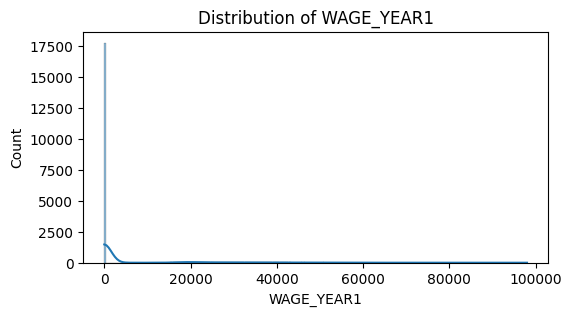

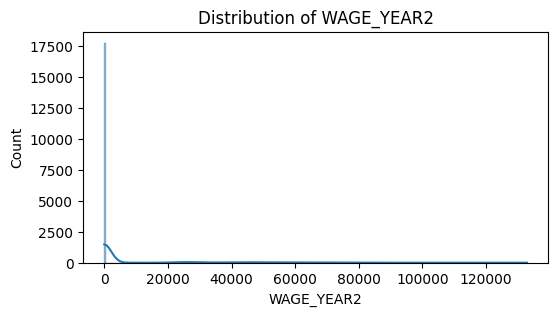

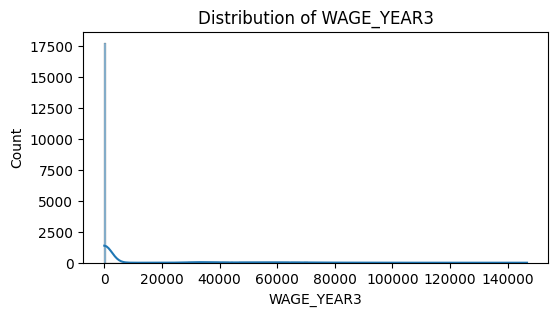

In [ ]:
# numeric distributions

num_cols = ["WAGE_YEAR1", "WAGE_YEAR2", "WAGE_YEAR3"]
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.show()


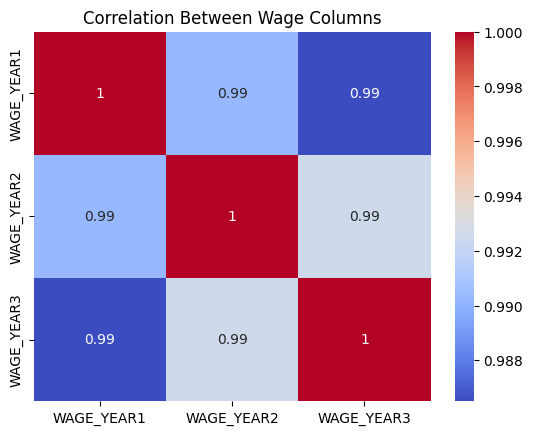

In [ ]:
# correlation between wage columns

corr = train_df[["WAGE_YEAR1", "WAGE_YEAR2", "WAGE_YEAR3"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Wage Columns")
plt.show()


In [ ]:
# prepare features (X) and target (y)

X = train_df.drop(columns=["WAGE_YEAR4"], errors="ignore")
y = train_df["WAGE_YEAR4"]

# drop unhelpful text fields with too many unique categories
drop_cols = ["DISTRICT_NAME"]
X = X.drop(columns=drop_cols, errors="ignore")

# split for model validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape, "Validation shape:", X_val.shape)


Training shape: (16564, 9) Validation shape: (4141, 9)


In [ ]:
# model: linear regression pipeline

categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model.fit(X_train, y_train)
print("Model trained successfully.")


Model trained successfully.


In [ ]:
# model performance

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 2500.32


In [ ]:
# predictions on test set

test_features = test_df.drop(columns=["WAGE_YEAR4"], errors="ignore")
test_preds = model.predict(test_features)

preds_df = pd.DataFrame(test_preds, columns=["WAGE_YEAR4"])
preds_df.to_csv("preds.csv", index=False)

print("Predictions saved to preds.csv")
preds_df.head()


Predictions saved to preds.csv


,WAGE_YEAR4
0,121.210080
1,42617.753730
2,179.021036
3,147.771159
4,36837.927397
